In [1]:
import os
import sys

sys.path.append("/opt/Mask_RCNN")
sys.path.append("/opt/Mask_RCNN/samples/coco/")

import mrcnn.model as model_mask_lib
from mrcnn import visualize
from mrcnn.config import Config
import imgaug

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from coco import CocoDataset
from coco import CocoConfig

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load Datasets 

#### Load Train

In [4]:
#Load Dataset Car Pose
dataset_train = CocoDataset()
dir(dataset_train)
teeth_coco = dataset_train.load_coco("/workspace/teeth_net/TEETH_DATASET/", "train", year=2019, return_coco=True, auto_download=False)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [5]:
dataset_train.prepare()

#### Load Val

In [6]:
# Validation dataset
dataset_val = CocoDataset()
dataset_val.load_coco("/workspace/teeth_net/TEETH_DATASET/", "val",  year=2018, return_coco=True, auto_download=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


#### Visualize dataset

In [6]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

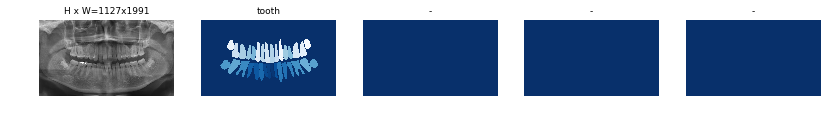

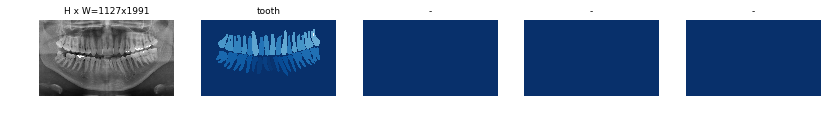

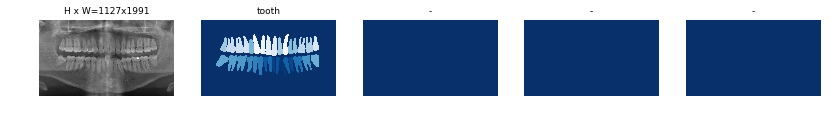

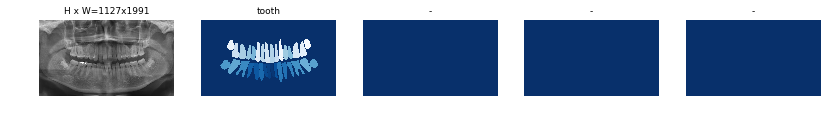

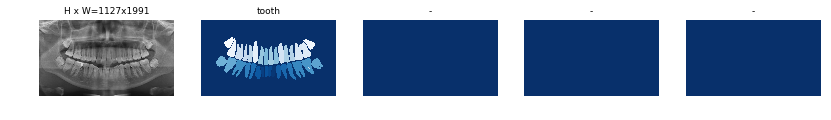

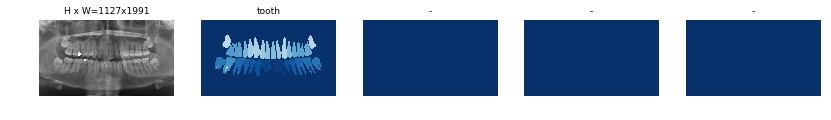

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 6)
#image_ids = np.hstack((image_ids, dataset_train.image_ids[:4]))
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### Configuration from train 

In [10]:
class TeethConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "teeth"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    STEPS_PER_EPOCH = 90

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # BG has 80 classes


In [11]:
config_train = TeethConfig()

In [12]:
ROOT_LOGS = "/workspace/teeth_net/logs_30_05"
model = model_mask_lib.MaskRCNN(mode="training", config=config_train, model_dir=ROOT_LOGS)

In [13]:
#augmentation = imgaug.augmenters.Fliplr(0.5)
# Load weights
print("Loading weights", "/opt/Mask_RCNN/mask_rcnn_coco.h5")
model_path = "/opt/Mask_RCNN/mask_rcnn_coco.h5"
model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])


Loading weights /opt/Mask_RCNN/mask_rcnn_coco.h5


In [14]:
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_train,
            learning_rate=config_train.LEARNING_RATE,
            epochs=10,
            layers='heads')

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_train,
            learning_rate=config_train.LEARNING_RATE,
            epochs=50,
            layers='4+')

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_train,
            learning_rate=config_train.LEARNING_RATE / 10,
            epochs=100,
            layers='all')


Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /workspace/teeth_net/logs_30_05/teeth20180530T1318/mask_rcnn_teeth_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (T

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
90/90 [==============================] - 467s 5s/step - loss: 2.2684 - rpn_class_loss: 0.1705 - rpn_bbox_loss: 0.6627 - mrcnn_class_loss: 0.5007 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.4505 - val_loss: 1.3804 - val_rpn_class_loss: 0.0561 - val_rpn_bbox_loss: 0.3129 - val_mrcnn_class_loss: 0.3289 - val_mrcnn_bbox_loss: 0.3381 - val_mrcnn_mask_loss: 0.3443
Epoch 2/10
90/90 [==============================] - 363s 4s/step - loss: 1.2426 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.3162 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.3219 - val_loss: 1.1340 - val_rpn_class_loss: 0.0473 - val_rpn_bbox_loss: 0.2328 - val_mrcnn_class_loss: 0.2887 - val_mrcnn_bbox_loss: 0.2665 - val_mrcnn_mask_loss: 0.2987
Epoch 3/10
90/90 [==============================] - 432s 5s/step - loss: 1.1079 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.2890 - val_loss: 1.0353 - val_rpn_class_loss: 0

Epoch 11/50
90/90 [==============================] - 359s 4s/step - loss: 0.7406 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.1799 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2240 - val_loss: 0.6313 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 0.1305 - val_mrcnn_class_loss: 0.1641 - val_mrcnn_bbox_loss: 0.1127 - val_mrcnn_mask_loss: 0.2051
Epoch 12/50
90/90 [==============================] - 270s 3s/step - loss: 0.6588 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.1801 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.2118 - val_loss: 0.6112 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 0.1306 - val_mrcnn_class_loss: 0.1591 - val_mrcnn_bbox_loss: 0.0984 - val_mrcnn_mask_loss: 0.2068
Epoch 13/50
90/90 [==============================] - 345s 4s/step - loss: 0.5983 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2016 - val_loss: 0.6016 - val_rpn_class_loss

Epoch 33/50
90/90 [==============================] - 303s 3s/step - loss: 0.3514 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1657 - val_loss: 0.3424 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.0515 - val_mrcnn_class_loss: 0.0791 - val_mrcnn_bbox_loss: 0.0395 - val_mrcnn_mask_loss: 0.1677
Epoch 34/50
90/90 [==============================] - 282s 3s/step - loss: 0.3450 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1678 - val_loss: 0.3403 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.0483 - val_mrcnn_class_loss: 0.0868 - val_mrcnn_bbox_loss: 0.0389 - val_mrcnn_mask_loss: 0.1621
Epoch 35/50
90/90 [==============================] - 300s 3s/step - loss: 0.3279 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1635 - val_loss: 0.3456 - val_rpn_class_loss

Epoch 51/100
90/90 [==============================] - 398s 4s/step - loss: 0.2483 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.1473 - val_loss: 0.2457 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.0243 - val_mrcnn_class_loss: 0.0500 - val_mrcnn_bbox_loss: 0.0217 - val_mrcnn_mask_loss: 0.1479
Epoch 52/100
90/90 [==============================] - 312s 3s/step - loss: 0.2268 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.1414 - val_loss: 0.2239 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.0181 - val_mrcnn_class_loss: 0.0469 - val_mrcnn_bbox_loss: 0.0178 - val_mrcnn_mask_loss: 0.1389
Epoch 53/100
90/90 [==============================] - 302s 3s/step - loss: 0.2260 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.1436 - val_loss: 0.2303 - val_rpn_class_l

Process Process-42:
Process Process-48:
Process Process-41:
Process Process-53:
Process Process-54:
Process Process-52:
Process Process-49:
Process Process-38:
Process Process-39:
Process Process-51:
Process Process-43:
Process Process-47:
Process Process-50:
Process Process-45:
Process Process-44:
Process Process-40:


KeyboardInterrupt: 

## Evalution by class

In [25]:
inference_config = coco_car_poses.InferenceConfig()

model_inference = model_mask_lib.MaskRCNN(mode="inference", config=inference_config,
                          model_dir=ROOT_LOGS)

In [28]:
#coco_car_poses.evaluate_coco(model_inference, dataset_val, coco_train, "bbox")

Loading and preparing results...


AssertionError: Results do not correspond to current coco set

In [ ]:
#coco_car_poses.evaluate_coco(model_inference, dataset_val, car_poses_coco, "segm")